# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [79]:
df = pd.read_csv("C:\\Users\\paresh\\Downloads\\customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [81]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [82]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [83]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [84]:

df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [85]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [86]:
df.shape

(50000, 14)

In [87]:
#null values

df.isnull().sum()

#there is no null values

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [88]:
df.booking_complete.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [89]:
# Separating categorical and numerical columns
data_categorical = df.select_dtypes(include="object")
data_numerical = df.select_dtypes(exclude="object")

In [90]:
data_categorical.head()

,sales_channel,trip_type,route,booking_origin
0,Internet,RoundTrip,AKLDEL,New Zealand
1,Internet,RoundTrip,AKLDEL,New Zealand
2,Internet,RoundTrip,AKLDEL,India
3,Internet,RoundTrip,AKLDEL,New Zealand
4,Internet,RoundTrip,AKLDEL,India


In [91]:
for col in data_categorical:
    print(data_categorical[col].value_counts())
    print("\n")

Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64


RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64


AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: route, Length: 799, dtype: int64


Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64




In [92]:
data_categorical.columns

Index(['sales_channel', 'trip_type', 'route', 'booking_origin'], dtype='object')

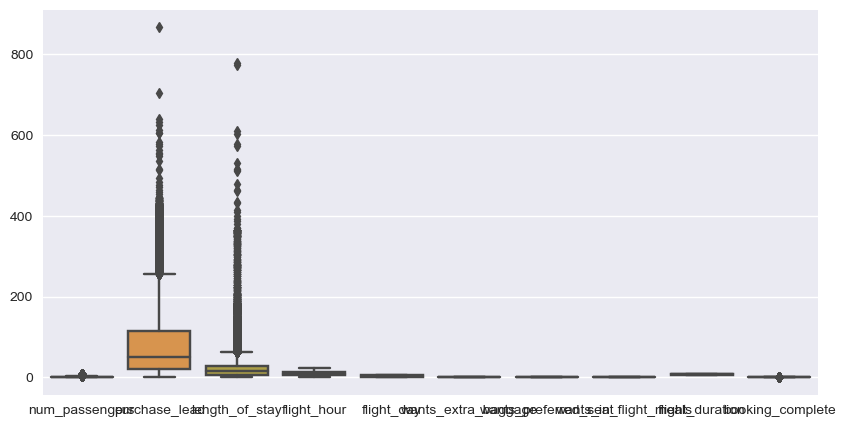

In [93]:
# Plotting boxplot for detecting outliers
plt.figure(figsize=(10,5))
sns.boxplot(data = data_numerical)
plt.show()

In [94]:
data_numerical.columns

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

In [95]:
import numpy as np

column_list = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
               'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
               'flight_duration']

for feature in column_list:
    Q1 = data_numerical[feature].quantile(0.25)
    Q3 = data_numerical[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    median = data_numerical[feature].median()
    
    data_numerical[feature] = np.where(data_numerical[feature] < lower_limit,
                                       median,
                                       data_numerical[feature])
    data_numerical[feature] = np.where(data_numerical[feature] > upper_limit,
                                       median,
                                       data_numerical[feature])


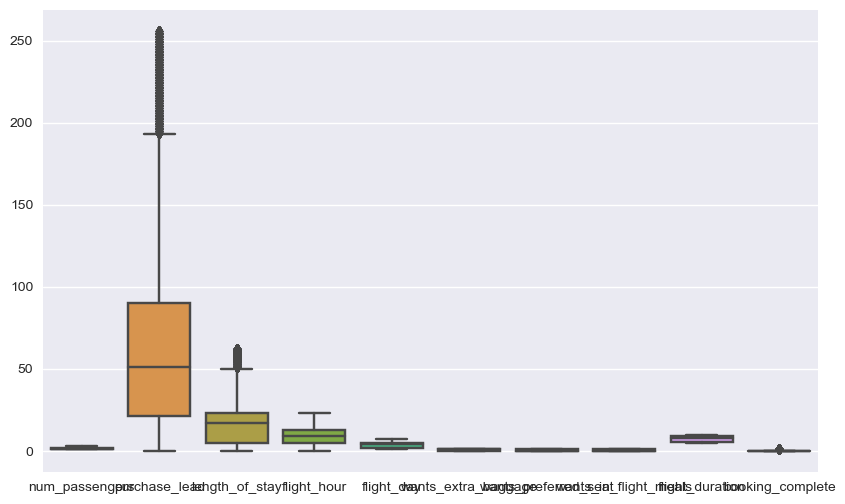

In [96]:
# Plotting boxplot for detecting outliers
plt.figure(figsize=(10,6))
sns.boxplot(data = data_numerical)
plt.show()

In [97]:
# combining numerical and categorical column data
df = pd.concat([data_categorical,data_numerical], axis =1)
df.head()

,sales_channel,trip_type,route,booking_origin,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,Internet,RoundTrip,AKLDEL,New Zealand,2.0,51.0,19.0,7.0,6,1.0,0.0,0.0,5.52,0
1,Internet,RoundTrip,AKLDEL,New Zealand,1.0,112.0,20.0,3.0,6,0.0,0.0,0.0,5.52,0
2,Internet,RoundTrip,AKLDEL,India,2.0,243.0,22.0,17.0,3,1.0,1.0,0.0,5.52,0
3,Internet,RoundTrip,AKLDEL,New Zealand,1.0,96.0,31.0,4.0,6,0.0,0.0,1.0,5.52,0
4,Internet,RoundTrip,AKLDEL,India,2.0,68.0,22.0,15.0,3,1.0,0.0,1.0,5.52,0


In [98]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete         

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [99]:
X

,sales_channel,trip_type,route,booking_origin,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,0,0,0,0,2.0,51.0,19.0,7.0,6,1.0,0.0,0.0,5.52
1,0,0,0,0,1.0,112.0,20.0,3.0,6,0.0,0.0,0.0,5.52
2,0,0,0,1,2.0,243.0,22.0,17.0,3,1.0,1.0,0.0,5.52
3,0,0,0,0,1.0,96.0,31.0,4.0,6,0.0,0.0,1.0,5.52
4,0,0,0,1,2.0,68.0,22.0,15.0,3,1.0,0.0,1.0,5.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,638,36,2.0,27.0,6.0,9.0,6,1.0,0.0,1.0,5.62
49996,0,0,638,36,1.0,111.0,6.0,4.0,7,0.0,0.0,0.0,5.62
49997,0,0,638,36,1.0,24.0,6.0,22.0,6,0.0,0.0,1.0,5.62
49998,0,0,638,36,1.0,15.0,6.0,11.0,1,1.0,0.0,1.0,5.62


In [100]:
X.dtypes

sales_channel              int64
trip_type                  int64
route                      int64
booking_origin             int64
num_passengers           float64
purchase_lead            float64
length_of_stay           float64
flight_hour              float64
flight_day                 int64
wants_extra_baggage      float64
wants_preferred_seat     float64
wants_in_flight_meals    float64
flight_duration          float64
dtype: object

In [101]:
y

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: booking_complete, Length: 50000, dtype: int64

In [102]:
y.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [103]:
print(X.shape)
print(y.shape)

(50000, 13)
(50000,)


In [104]:
# using imblearn to removing imablance in our dataset
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X, y)
print(x_smote.shape)
print(y_smote.shape)

(85044, 13)
(85044,)


In [105]:
y_smote.head()

0    0
1    0
2    0
3    0
4    0
Name: booking_complete, dtype: int64

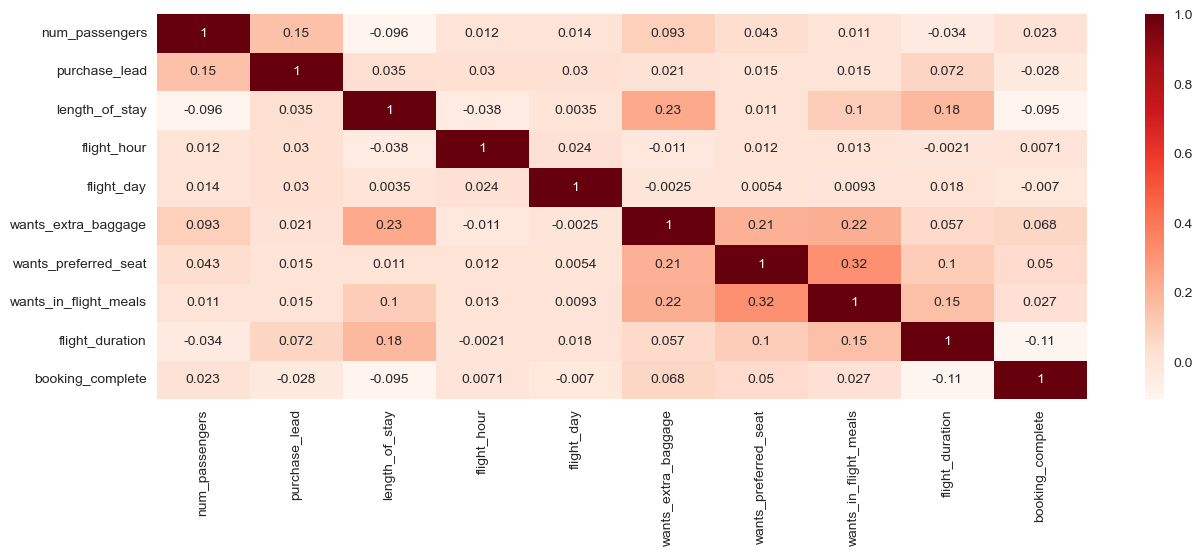

In [106]:
# Plotting heatmap 
plt.figure(figsize=(15,5))
sns.heatmap(data_numerical.corr() , annot=True, cmap="Reds")
plt.show()

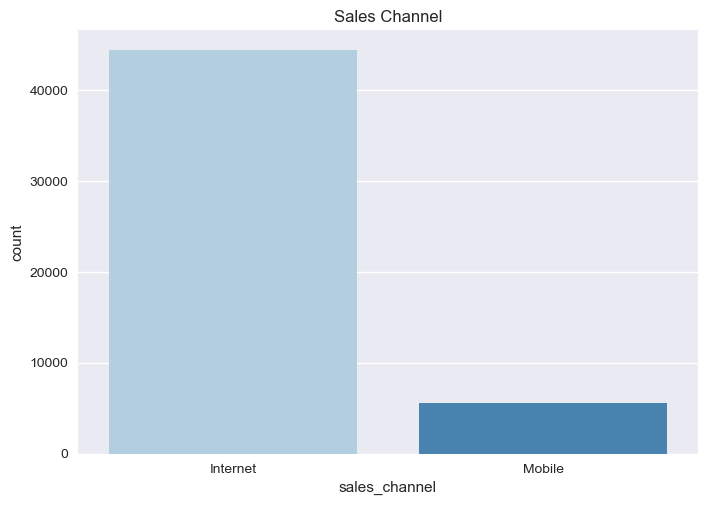

In [107]:
# sales channel
plt.style.use('seaborn')
sns.countplot(x='sales_channel',data=df ,palette='Blues')
plt.title('Sales Channel')
sns.despine()

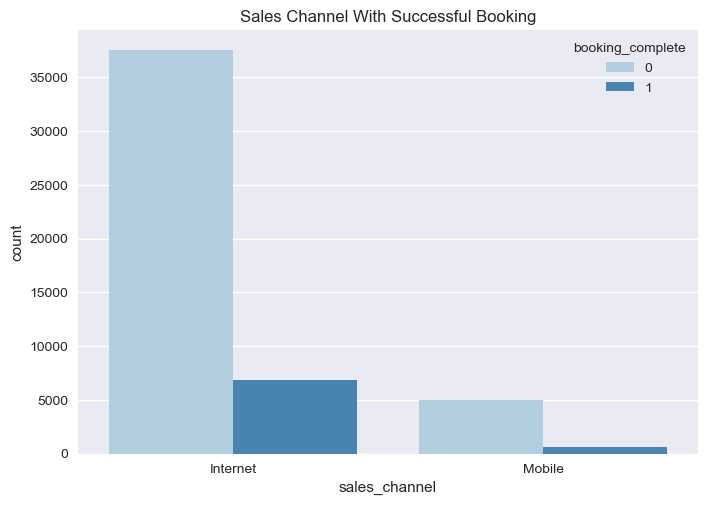

In [109]:
# sales channel with successful booking
sns.countplot(x='sales_channel',data=df,hue='booking_complete',palette='Blues')
plt.title('Sales Channel With Successful Booking')
sns.despine()

In [110]:
# sales channel in %
internet_sale = df.sales_channel.value_counts().values[0]  / df.sales_channel.count() *100
mobile_sale = df.sales_channel.value_counts().values[1]  / df.sales_channel.count() *100
print(f"Number of bookings done through internet: {internet_sale} %")
print(f"Number of bookings done through phone call: {mobile_sale} %")

Number of bookings done through internet: 88.764 %
Number of bookings done through phone call: 11.236 %


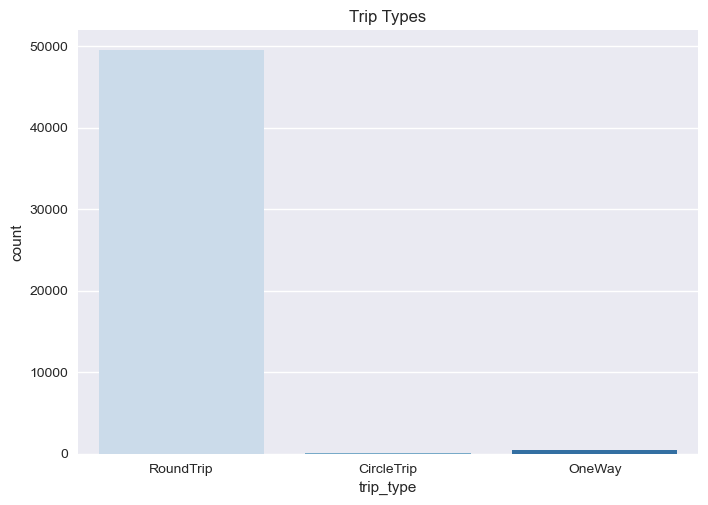

In [111]:
# tripe types
sns.countplot(x='trip_type',data=df,palette='Blues')
plt.title('Trip Types')
sns.despine()

In [112]:
# trip type in %
round_trip = df.trip_type.value_counts().values[0]/ df.trip_type.count() *100
oneway_trip = df.trip_type.value_counts().values[1]/ df.trip_type.count() *100
circle_trip = df.trip_type.value_counts().values[2]/ df.trip_type.count() *100
print(f"Percentage of round trips: {round_trip} %")
print(f"Percentage of One way trips: {oneway_trip} %")
print(f"Percentage of circle trips: {circle_trip} %")

Percentage of round trips: 98.994 %
Percentage of One way trips: 0.774 %
Percentage of circle trips: 0.232 %


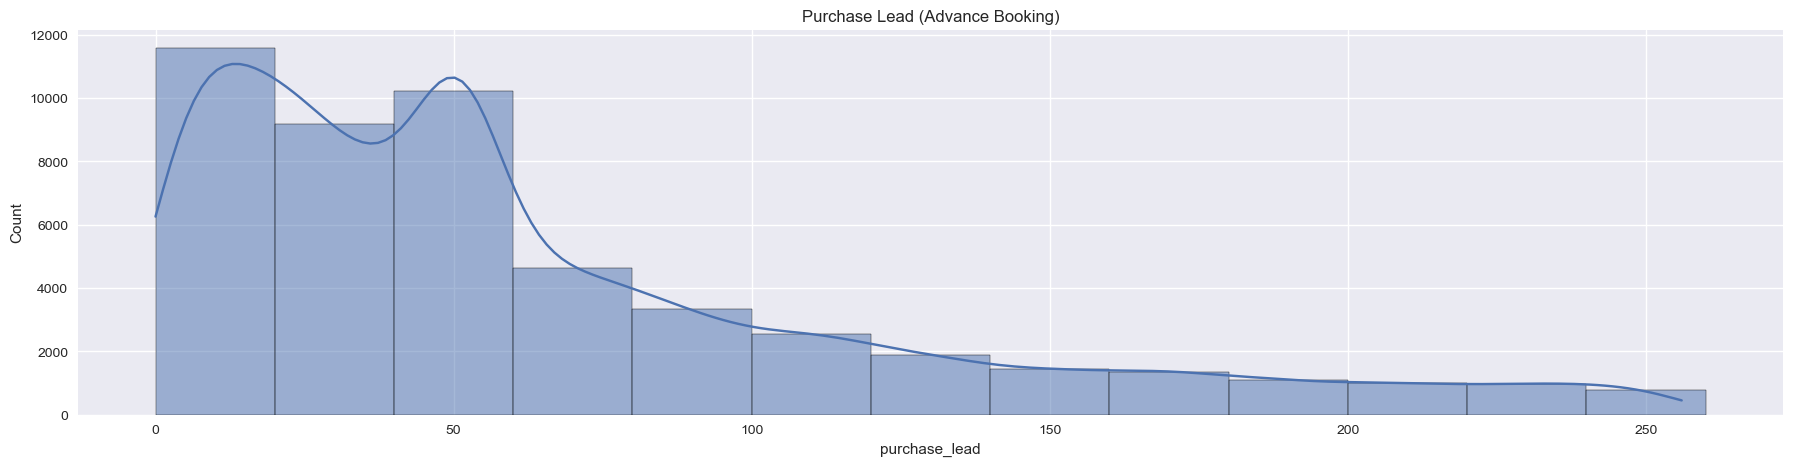

In [113]:
# purchase lead
plt.figure(figsize=(22,5))
sns.histplot(data=df, x="purchase_lead", binwidth=20,kde=True)
plt.title('Purchase Lead (Advance Booking)')
plt.show()

From the above visualization we can understand that most of the purchase lead (advance booking) is in between 0 to 250 days there for the purchase lead which is more than 250 days we will treat them as outliers to increase the accuracy of the predictive modeling

In [114]:
# Checking the purchase lead with more than 600 days
(df.purchase_lead >250).value_counts()

False    49765
True       235
Name: purchase_lead, dtype: int64

There are only 235 purchase lead with more than 250 days of advance booking hence we will remove them

In [115]:
# data with more than 250 days of purchase lead
df[df.purchase_lead > 250]

,sales_channel,trip_type,route,booking_origin,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
375,Internet,RoundTrip,AKLKUL,New Zealand,1.0,253.0,17.0,10.0,3,0.0,0.0,0.0,8.83,0
409,Internet,RoundTrip,AKLKUL,New Zealand,2.0,254.0,30.0,8.0,5,1.0,0.0,0.0,8.83,0
435,Internet,RoundTrip,AKLKUL,Malaysia,2.0,255.0,33.0,10.0,6,1.0,0.0,0.0,8.83,0
467,Internet,RoundTrip,AKLKUL,Malaysia,1.0,252.0,25.0,9.0,2,0.0,0.0,0.0,8.83,1
471,Internet,RoundTrip,AKLKUL,United Kingdom,1.0,254.0,60.0,20.0,2,0.0,0.0,0.0,8.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49031,Internet,RoundTrip,MELTPE,Taiwan,1.0,251.0,6.0,1.0,7,1.0,1.0,1.0,8.83,0
49044,Internet,RoundTrip,MELTPE,Taiwan,1.0,253.0,6.0,1.0,6,0.0,0.0,0.0,8.83,0
49168,Internet,RoundTrip,MLETPE,Taiwan,2.0,254.0,6.0,15.0,1,1.0,0.0,1.0,4.67,0
49621,Internet,RoundTrip,PENPER,Australia,3.0,252.0,6.0,8.0,7,0.0,0.0,0.0,5.62,0


In [116]:
# filtering the data to have only purchase lead days less than 600 days
data = df[df.purchase_lead <250 ]

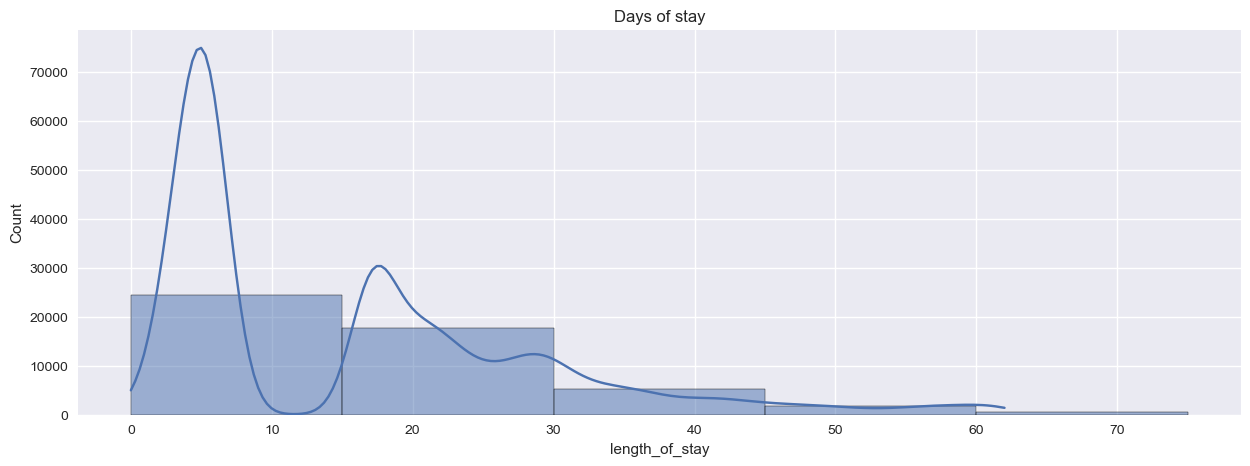

In [117]:
# Length Of Stay
plt.figure(figsize=(15,5))
sns.histplot(data=data, x="length_of_stay", binwidth=15,kde=True)
plt.title('Days of stay')
plt.show()

From the above visualization we can understand that most of the length of stays (days stay) is in between 0 to 10 but we also have length of stay with more than 10 . hence we will focus on the length of stay till more than 60 days

In [118]:
# Checking the data for length of stay with more then 100 days
(data.length_of_stay> 50).value_counts()

False    48332
True      1384
Name: length_of_stay, dtype: int64

In [119]:
data[data.length_of_stay> 60].booking_complete.value_counts()

0    255
1     48
Name: booking_complete, dtype: int64

In [120]:
data = data[data.purchase_lead <60 ]

In [121]:
data.shape  

(30989, 14)

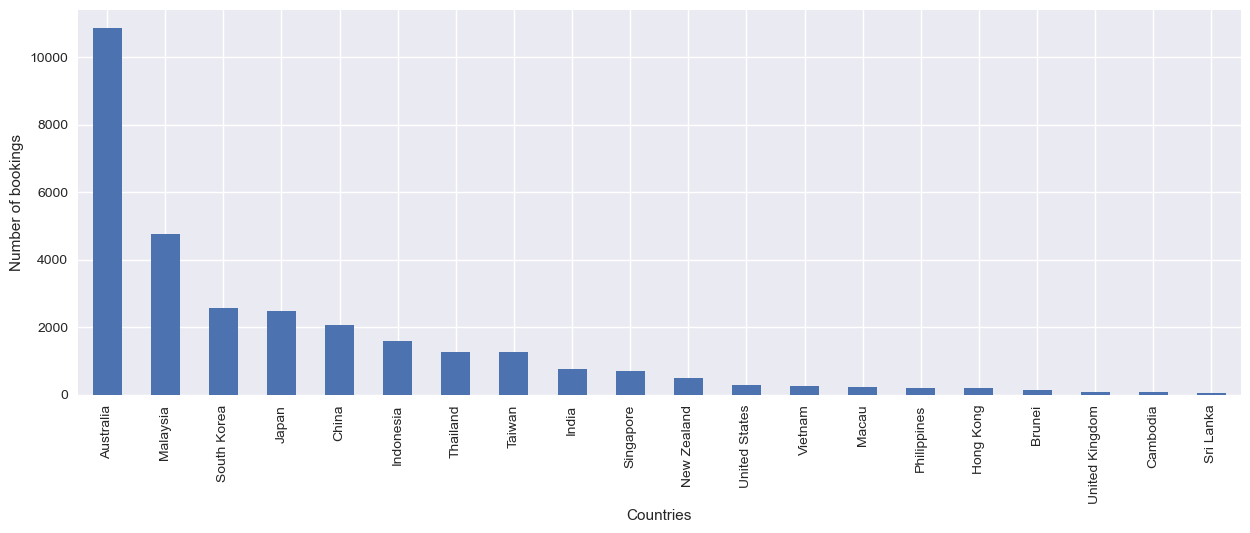

In [122]:
# travellers from which country had maximum booking applications (top 20 countrys)
plt.figure(figsize=(15,5))
ax = data.booking_origin.value_counts()[:20].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of bookings")
plt.show()

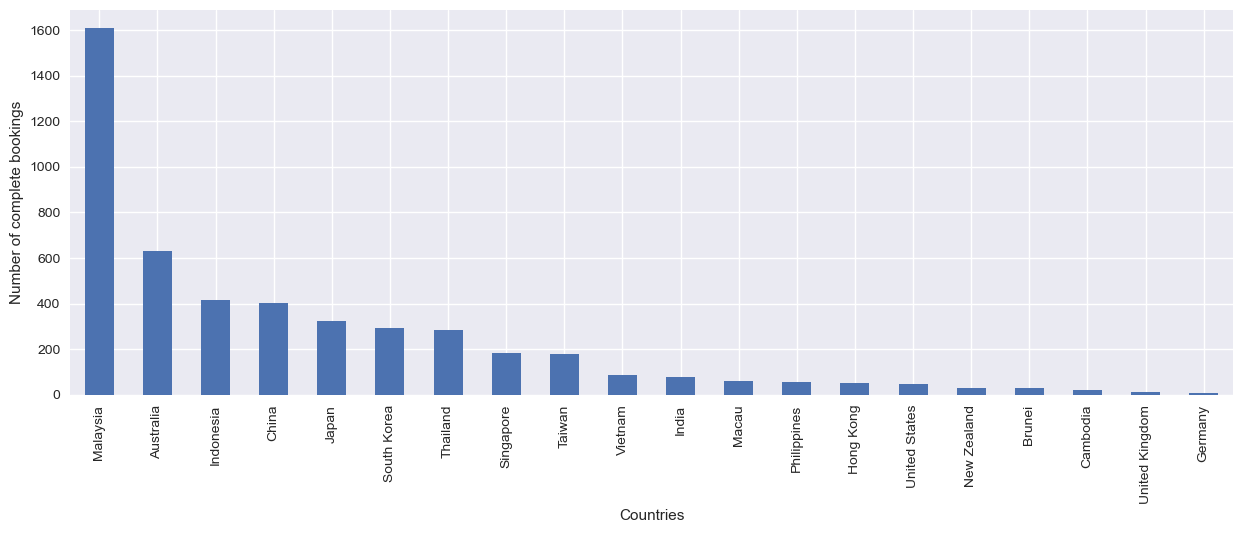

In [123]:
# travellers from which country had their booking complete (top 20 countrys)
plt.figure(figsize=(15,5))
ax = data[data.booking_complete ==1].booking_origin.value_counts()[:20].plot(kind="bar")
ax.set_xlabel('Countries')
ax.set_ylabel('Number of complete bookings')
plt.show()

In [124]:
# looking for % of successfull booking in 50000 entries
successful_booking = data.booking_complete.value_counts().values[0] / len(data) * 100
unsuccessful_booking = 100-successful_booking
print(f"Out of 50000 booking entries only {round(unsuccessful_booking,2)} % bookings were successfull or complete.")

Out of 50000 booking entries only 15.81 % bookings were successfull or complete.


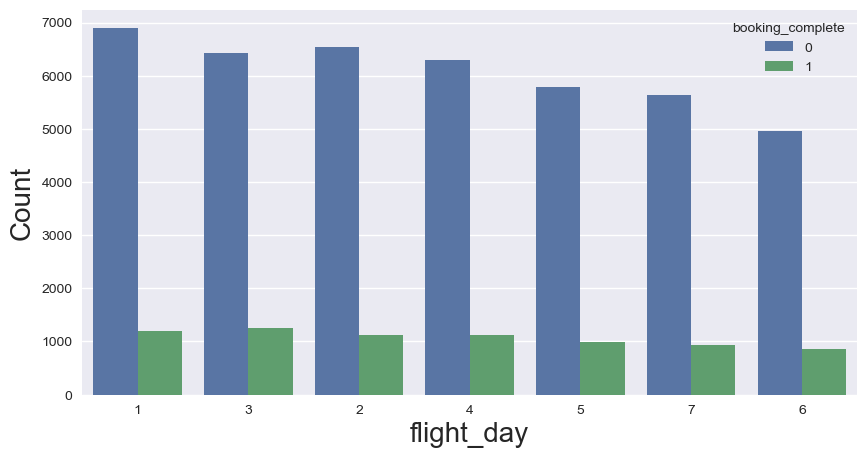

In [125]:
plt.figure(figsize=(10, 5))
sns.countplot(x="flight_day", hue="booking_complete", data=df, order=df["flight_day"].value_counts().index)
plt.xlabel("flight_day", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.show()


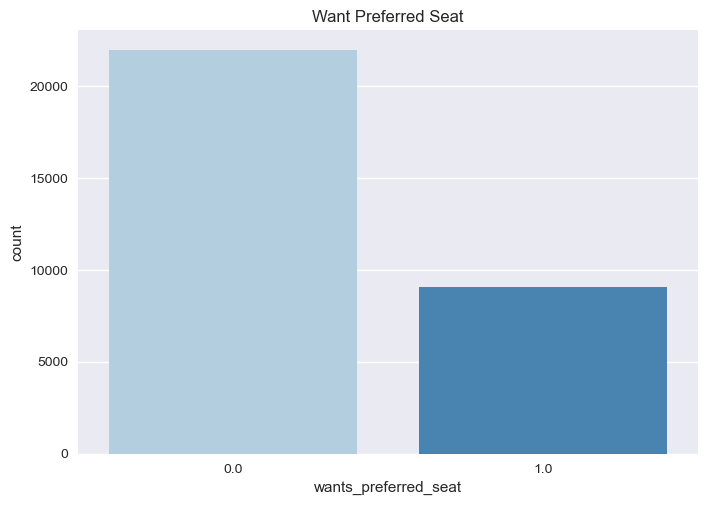

In [126]:
# wants preferred seat
sns.countplot(x='wants_preferred_seat', data=data, palette='Blues')
plt.title('Want Preferred Seat')
plt.show()

In [134]:
percentage_wants_preferred_seat = data['wants_preferred_seat'].value_counts(normalize=True) * 100

print("Percentage of Wants Preferred Seat:")
print(percentage_wants_preferred_seat)


Percentage of Wants Preferred Seat:
0.0    70.812224
1.0    29.187776
Name: wants_preferred_seat, dtype: float64


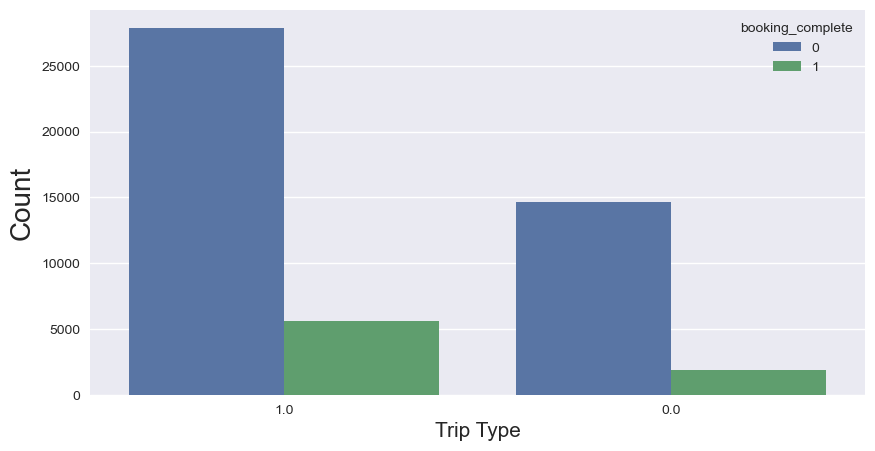

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plots = sns.countplot(x="wants_extra_baggage", hue="booking_complete", data=df, order=df["wants_extra_baggage"].value_counts().index)
plt.xlabel("Trip Type", fontsize=15)
plt.ylabel("Count", fontsize=20)
plt.show()


In [133]:
percentage_wants_extra_baggage = df['wants_extra_baggage'].value_counts(normalize=True) * 100

print("Percentage of Wants Extra Baggage:")
print(percentage_wants_extra_baggage)

Percentage of Wants Extra Baggage:
1.0    66.878
0.0    33.122
Name: wants_extra_baggage, dtype: float64


In [130]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Assuming you have already defined X (feature matrix) and y (target variable)

mi_scores = pd.Series(mutual_info_classif(X, y), name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores)  # Display the top 5 features with their MI scores

route                    0.054661
booking_origin           0.047253
flight_duration          0.016628
length_of_stay           0.007053
num_passengers           0.004980
wants_extra_baggage      0.003663
wants_in_flight_meals    0.002921
sales_channel            0.002576
trip_type                0.002085
flight_hour              0.001777
wants_preferred_seat     0.001191
purchase_lead            0.001042
flight_day               0.000270
Name: MI Scores, dtype: float64


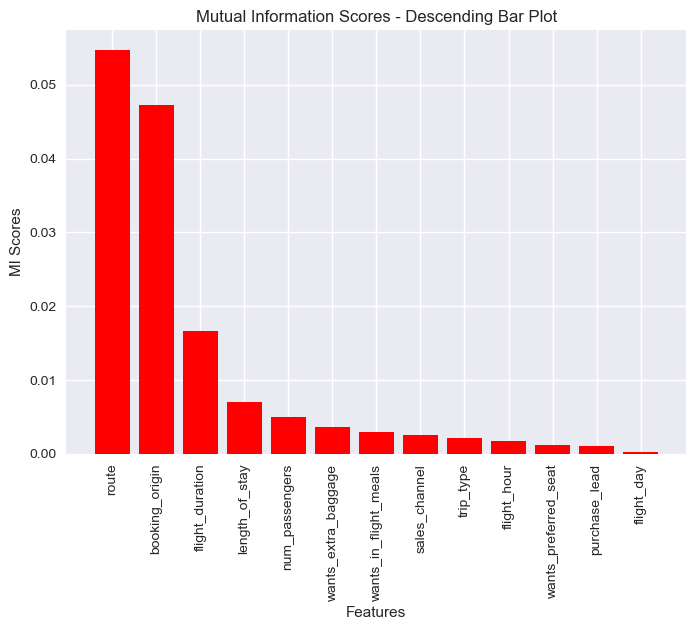

In [131]:
def plot_descending_bar_mi_scores(scores, color='blue'):
    scores = scores.sort_values(ascending=False)  # Sort scores in descending order
    colors = [color] * len(scores)  # Create a list of colors for each bar
    plt.bar(scores.index, scores, color=colors)
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('MI Scores')
    plt.title('Mutual Information Scores - Descending Bar Plot')
    plt.show()

# Assuming you have already calculated the mi_scores

plot_descending_bar_mi_scores(mi_scores, color='red')

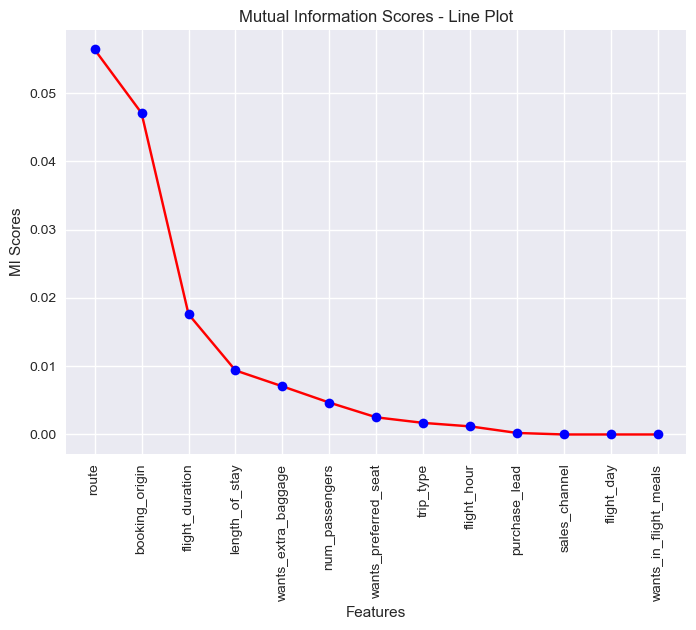

In [59]:
def plot_line_mi_scores(scores, line_color='red', marker_color='blue'):
    scores = scores.sort_values(ascending=False)
    plt.plot(scores.index, scores, marker='o', color=line_color, markerfacecolor=marker_color)
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('MI Scores')
    plt.title('Mutual Information Scores - Line Plot')
    plt.show()

# Assuming you have already calculated the mi_scores

plot_line_mi_scores(mi_scores, line_color='red', marker_color='blue')

#test train and validation split of data

In [60]:
#test train split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.25,random_state = 0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X    

# Model Random forest classifier with top 6 features

In [61]:

#assigning the features under a list

features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']
X= df[features]
#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  83.224
AUC score:  0.5591697119569896


In [63]:
from sklearn.metrics import classification_report

# Making predictions on the test set
preds_test = forest_model.predict(X_val)

# Printing the classification report for the test set
print(classification_report(y_val, preds_test))



              precision    recall  f1-score   support

           0       0.86      0.95      0.91     10608
           1       0.38      0.17      0.23      1892

    accuracy                           0.83     12500
   macro avg       0.62      0.56      0.57     12500
weighted avg       0.79      0.83      0.80     12500



#Random forest classifier with all features

In [67]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model1= RandomForestClassifier(random_state=1)
forest_model1.fit(X_train, y_train)
preds= forest_model1.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  84.856
AUC score:  0.553151277586982


In [68]:
# Making predictions on the validation set
preds_val = forest_model1.predict(X_val)

# Printing the classification report for the validation set
print(classification_report(y_val, preds_val))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     10608
           1       0.50      0.13      0.21      1892

    accuracy                           0.85     12500
   macro avg       0.68      0.55      0.56     12500
weighted avg       0.81      0.85      0.81     12500



#confussion Matrix

In [69]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val, preds)
print("Confusion Matrix:")
print(conf_matrix)
accuracy = accuracy_score(y_val, preds)
print("Accuracy:", accuracy*100)
print('AUC score: ',roc_auc_score(y_val,preds))




Confusion Matrix:
[[10362   246]
 [ 1647   245]]
Accuracy: 84.856
AUC score:  0.553151277586982


#Model With GradientBoostingClassifier

In [71]:

from sklearn.ensemble import GradientBoostingClassifier

boost_model = GradientBoostingClassifier(random_state=1)
boost_model.fit(X_train, y_train)
boost_preds = boost_model.predict(X_val)

boost_accuracy = accuracy_score(y_val, boost_preds)
print("Boosting Accuracy:", boost_accuracy*100)
print('AUC score: ',roc_auc_score(y_val,preds))

Boosting Accuracy: 84.792
AUC score:  0.553151277586982


#XGB classifier with top 6 features

In [72]:
from xgboost import XGBClassifier

X= df[features]

#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)

y= df.booking_complete    

X_train,X_val,y_train,y_val= dataset(X,y)
xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.848
AUC score:  0.5257449601242351


#Model with XG Boost all features

In [73]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_preds)
print("XGBoost Accuracy:", xgb_accuracy*100)
print('AUC score: ',roc_auc_score(y_val,xgb_preds))

XGBoost Accuracy: 84.848
AUC score:  0.5257449601242351


#Model After HyperParameter tunning

In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Define the parameter grid for RandomForestClassifier with reduced values
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Create the GridSearchCV object for RandomForestClassifier
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=1),
                              param_grid=rf_param_grid, cv=5, n_jobs=-1)
# Fit the grid search to the training data
rf_grid_search.fit(X_train, y_train)

# Get the best parameters and best score for RandomForestClassifier
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

print("Random Forest Best Parameters:", rf_best_params)
print("Random Forest Best Score:", rf_best_score*100)

Random Forest Best Parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best Score: 85.36888888888889


In [136]:
preds_val = rf_grid_search.predict(X_val)
auc_score_val = roc_auc_score(y_val, preds_val)
print('AUC score: ',auc_score_val)

AUC score:  0.5


In [137]:
from tabulate import tabulate

# Define the data for the table
data = [
    ["Random forest classifier with top 6 features", 85.224, 0.559],
    ["Random forest classifier with all features", 84.856, 0.5531],
    ["Confusion Matrix", 84.856, 0.5531],
    ["GradientBoostingClassifier", 84.792, 0.54182],
    ["XGB classifier with top 6 features", 84.848, 0.52574],
    ["Model with XG Boost all features", 84.848, 0.52574],
    ["Model after HyperParameter tuning", 85.368, 0.5]
]

# Define the headers for the table
headers = ["Model", "Accuracy", "AUC score"]

# Generate the table
table = tabulate(data, headers, tablefmt="grid")

# Print the table
print(table)


+----------------------------------------------+------------+-------------+
| Model                                        |   Accuracy |   AUC score |
+==============================================+============+=============+
| Random forest classifier with top 6 features |     83.224 |     0.559   |
+----------------------------------------------+------------+-------------+
| Random forest classifier with all features   |     84.856 |     0.5531  |
+----------------------------------------------+------------+-------------+
| Confusion Matrix                             |     84.856 |     0.5531  |
+----------------------------------------------+------------+-------------+
| GradientBoostingClassifier                   |     84.792 |     0.54182 |
+----------------------------------------------+------------+-------------+
| XGB classifier with top 6 features           |     84.848 |     0.52574 |
+----------------------------------------------+------------+-------------+
| Model with